In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_columns', None)

In [2]:
TRAINING_DATA_PATH = '/scratch/data/TrojAI/round7-train-dataset/'
RESULTS = 'results_4_triggers_4_candidates_jul7'

def get_metadata():
    metadata = pd.read_csv(join(TRAINING_DATA_PATH, 'METADATA.csv'))
    return metadata


def get_trigger_text(model_name):
    with open (join(TRAINING_DATA_PATH, 'models', model_name, 'config.json')) as json_file:
        config = json.load(json_file)
    return config['triggers'][0]['trigger_executor']['trigger_text']


def get_trigger_source_and_target(model_name):
    poisoned_file = os.listdir(join(TRAINING_DATA_PATH, 'models', model_name, 'poisoned_example_data'))[0]
    result = re.findall(r'source_class_(\d+)_target_class_(\d+)_', poisoned_file)
    return result

def id_str_to_model_id(id_str):
    id_str = str(100000000 + int(id_str))[1:]
    model_id = 'id-'+id_str
    return model_id

def get_all_files(path=RESULTS):
    df_list = []
    files = [f for f in os.listdir(path)]
    for f in files:
        temp_df = pd.read_csv(join(path, f))
        temp_df['model_name'] = id_str_to_model_id(f[:-4])
        df_list.append(temp_df)
    result = pd.concat(df_list)
    return result[['source_class', 'target_class', 'decoded_top_candidate', 
                   'trigger_asr', 'loss', 'model_name']]

df = get_all_files()
metadata = get_metadata()

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_original_merged.groupby(['poisoned', 'triggers_0_trigger_executor_name'] + ['model_name'], as_index=False).count()\
    .groupby(['poisoned', 'triggers_0_trigger_executor_name']).agg({'model_name':'count'})


model_name
poisoned triggers_0_trigger_executor_name            
False    None                                      95
True     character                                 24
         phrase                                    24
         word1                                     23
         word2                                     24

In [3]:
asr_threshold = .9

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_filtered = df_original_merged[df_original_merged['trigger_asr']>asr_threshold]

remaining_model_names = df_filtered['model_name'].unique()
all_model_names = df_original_merged['model_name'].unique()
missing_model_names = [i for i in all_model_names if i not in remaining_model_names]
df_missing_model_names = df_original_merged[df_original_merged['model_name'].isin(missing_model_names)]
df_missing_model_names_max_asr = df_missing_model_names.groupby('model_name').agg({'trigger_asr':'max'})
df_missing_model_names = df_missing_model_names_max_asr.merge(df_missing_model_names, on='model_name', how='left')

df_filtered = pd.concat([df_filtered, df_missing_model_names])

min_loss_df = df_filtered.groupby('model_name', as_index=False).agg({'loss':'min'})

def get_entry_with_min_loss(x):
    model_name = x['model_name']
    loss = x['loss']
    asr = x['trigger_asr']
    min_loss = min_loss_df[min_loss_df['model_name'] == model_name]['loss']
    x['mask'] = ((loss==min_loss).item()) & (asr>asr_threshold)
    return x

df_filtered = df_filtered.apply(get_entry_with_min_loss, axis=1)
# df_original_merged['mask']
df_filtered = df_filtered[df_filtered['mask']]
df_filtered

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding,embedding_level,embedding_flavor_level,embedding_flavor,source_dataset,source_dataset_level,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged,trigger_asr_x,trigger_asr_y,mask
155,11,9,con favor ##ing ##arth,0.980000,0.722107,id-00000065,True,1629177109,1,WarmupWithLinear,1,0,NerLinear,1,0.00005,1,16,0.01,5,0.2,MobileBERT,3,0,google/mobilebert-uncased,ontonotes-5.0,1,0,0.1,0,one2one,1,13,{'0': 'GPE' '1': 'PERSON' '2': 'DATE' '3': 'MO...,PERCENT,NORP,1,0.5,1,False,1,word1,0.020614,0.097812,0.046785,0.051026930093511884,10,38220.683187,1166.776656,97.354262,94.883032,93.906420,95.85964506271283,93.620802,96.64269814689459,100.0,100.0,0.986757,0.914980,0.935558,0.925155,GPE,0.954320,0.934805,0.954320,0.944461,PERSON,0.958877,0.952662,0.958877,0.955759,DATE,0.896004,0.854454,0.896004,0.874736,MONEY,0.921300,0.892295,0.921300,0.906566,NORP,0.9229685298262095,0.9260131950989633,0.9229685298262095,0.9244883556810162,PERCENT,0.9336099585062241,0.872093023255814,0.9336099585062241,0.9018036072144289,0.9891796183356286,0.9379370629370629,0.9563279857397504,0.9470432480141219,GPE,0.954954954954955,0.9298245614035

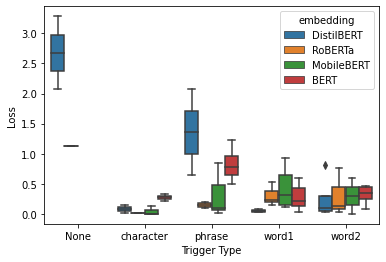

In [4]:
df_filtered = df_filtered.sort_values('triggers_0_trigger_executor_name')
sns.boxplot(data=df_filtered, x='triggers_0_trigger_executor_name', y='loss', hue='embedding')
# sns.stripplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', hue='triggers_0_global_trigger')
plt.xlabel('Trigger Type')
plt.ylabel('Loss')
plt.savefig('boxplot_two_trigger_asr>90pct_min_loss.jpg', dpi=2000)

Text(0, 0.5, 'Loss')

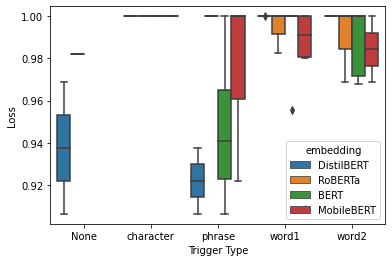

In [5]:
df_filtered = df_filtered.sort_values('triggers_0_trigger_executor_name')
sns.boxplot(data=df_filtered, x='triggers_0_trigger_executor_name', y='trigger_asr', hue='embedding')
plt.xlabel('Trigger Type')
plt.ylabel('Loss')
# plt.savefig('boxplot_two_trigger_asr>90pct_min_loss.jpg', dpi=2000)

In [6]:
df_filtered.groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'})

,model_name
triggers_0_trigger_executor_name,
None,3
character,9
phrase,11
word1,18
word2,14


In [7]:
df_original_merged.groupby('model_name', as_index=False).min().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'})

,model_name
triggers_0_trigger_executor_name,
None,95
character,24
phrase,24
word1,23
word2,24


In [8]:
missing_model_names = [i for i in df_original_merged.model_name.unique() if i not in df_filtered.model_name.unique()]
missing_models_df = df_original_merged[df_original_merged.model_name.isin(missing_model_names)]
missing_models_df[(missing_models_df['triggers_0_trigger_executor_name'] == 'word1')]

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding,embedding_level,embedding_flavor_level,embedding_flavor,source_dataset,source_dataset_level,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
528,1,3,‘ president ##rlene cyclone,0.227273,5.121134,id-00000144,True,1983679718,1,WarmupWithLinear,1,0,NerLinear,1,0.00005,1,16,0.01,5,0.2,DistilBERT,1,0,distilbert-base-cased,conll2003,2,0,0.1,0,one2one,1,9,{'0': 'MISC' '1': 'PER' '2': 'ORG' '3': 'LOC'},MISC,PER,1,0.5,0,True,1,word1,0.003618,0.132354,0.063562,0.0687916539935118,10,2380.141047,91.944919,99.510091,94.913241,95.098820,94.72766171855417,93.723463,91.86682809811813,100.0,100.0,0.987880,0.935913,0.946872,0.941360,MISC,0.861570,0.879747,0.861570,0.870564,PER,0.970326,0.958944,0.970326,0.964602,ORG,0.921683,0.912088,0.921683,0.916860,LOC,0.971227,0.951090,0.971227,0.961053,None,None,None,None,None,None,None,None,None,None,0.9846496657588512,0.9134709931170109,0.9216269841269841,0.9175308641975309,MISC,None,None,None,None,PER,0.9258698940998488,0.9161676646706587,0.9258698940998488,0.9209932279909706,ORG,0.8540145985401459,0.8540145985401459,0.8540145985401459,0.8540145985401459,LOC,0.9523809523809523

In [12]:
df_144 = df_original_merged[df_original_merged.model_name == 'id-00000190']

trigger_text = get_trigger_text('id-00000190')
result = get_trigger_source_and_target('id-00000190')
print(f'trigger text: {trigger_text}')
print(f'source and target class: {result}')

lst = ['source_class', 'target_class', 'loss', 'trigger_asr', 'decoded_top_candidate', 'triggers_0_source_class_label', 'triggers_0_target_class_label']
display(df_144[lst])

trigger text: nascent
source and target class: [('1', '7')]


,source_class,target_class,loss,trigger_asr,decoded_top_candidate,triggers_0_source_class_label,triggers_0_target_class_label


'id-00000144'

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='trigger_asr'>

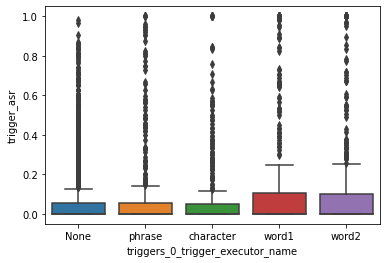

In [12]:
sns.boxplot(data=df_original_merged, x='triggers_0_trigger_executor_name', y='trigger_asr')

<AxesSubplot:xlabel='trigger_asr', ylabel='loss'>

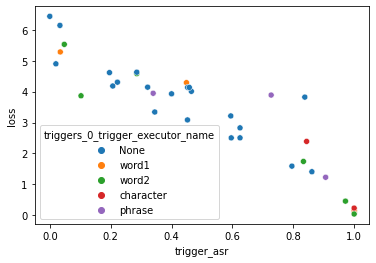

In [54]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['loss'] == min(x['loss'])])
sns.scatterplot(data=test, x='trigger_asr', y='loss', hue='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='trigger_asr', ylabel='loss'>

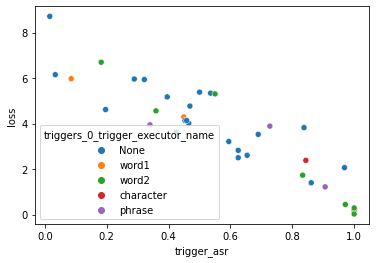

In [55]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['trigger_asr'] == max(x['trigger_asr'])])
sns.scatterplot(data=test, x='trigger_asr', y='loss', hue='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='loss'>

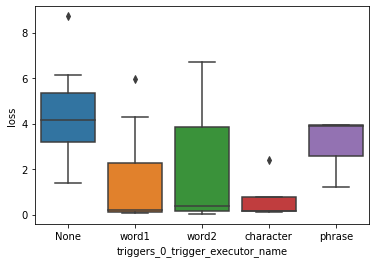

In [56]:
test = df_original_merged.groupby(['model_name']).apply(lambda x: x[x['trigger_asr'] == max(x['trigger_asr'])])
sns.boxplot(data=test, y='loss', x='triggers_0_trigger_executor_name')

<AxesSubplot:xlabel='triggers_0_trigger_executor_name', ylabel='loss'>

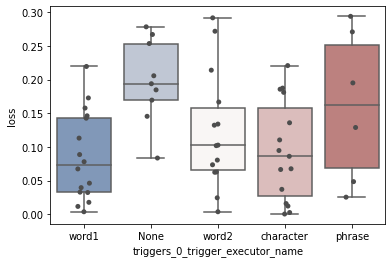

In [51]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=prediction_df, y='loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=prediction_df, y='loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
# plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [ ]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=prediction_df, y='loss', x='poisoned', ax=ax, palette='vlag')
sns.stripplot(data=prediction_df, y='loss', x='poisoned', ax=ax, color=".3")
# plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [38]:
lst=['poisoned', 'triggers_0_trigger_executor_name', 'model_name']
kept_df = prediction_df[list(df.columns)+lst]
kept_df = prediction_df.dropna()
kept_df.groupby(['poisoned', 'embedding_flavor']).agg({'model_name':'count'})

model_name
poisoned embedding_flavor                     
False    bert-base-uncased                   2
         distilbert-base-cased               6
         google/mobilebert-uncased           1
True     bert-base-uncased                  16
         distilbert-base-cased              11
         google/mobilebert-uncased          12
         roberta-base                       12

In [39]:
kept_df.groupby(['poisoned', 'source_dataset']).agg({'model_name':'count'})

model_name
poisoned source_dataset            
False    bbn-pcet                 6
         ontonotes-5.0            3
True     bbn-pcet                16
         conll2003               17
         ontonotes-5.0           18

In [48]:
metadata.triggers_0_trigger_executor_name

0        None
1        None
2        None
3       word1
4       word1
        ...  
187      None
188    phrase
189      None
190     word1
191      None
Name: triggers_0_trigger_executor_name, Length: 192, dtype: object

In [13]:
df[df['model_name']=='id-00000188'].sort_values('trigger_asr')

,source_class,target_class,decoded_top_candidate,trigger_asr,loss,model_name
0,0,1,¹ /,0.000000,7.144264,id-00000188
47,5,8,##´ blu,0.000000,9.180842,id-00000188
52,6,4,mu nu,0.000000,7.053196,id-00000188
54,6,7,##pop rep,0.000000,7.598391,id-00000188
55,6,8,kwan ##landa,0.000000,6.489341,id-00000188
...,...,...,...,...,...,...
45,5,6,turned southland,0.819672,3.380223,id-00000188
62,7,6,pontifical erasmus,0.838710,3.305595,id-00000188
17,2,1,##ntes eventual,1.000000,2.522153,id-00000188
57,7,1,stimulus particularly,1.000000,0.025519,id-00000188
